# Tagger Testing
This notebook is the result of initial experimentation with spacy's Swedish POS tagger. I wanted to get a sense for the difference between the taggers, and how they each perform across time. The hypothesis is that the sparv tagset will perform worse on older documents compared to spacy's tagset. They will both however likely struggle on older texts due to the poor level of OCR. There's no baseline we can use as a ground truth, so the sanity check is to see if the POS tags overlap less the further back you go in time. 

In [20]:
import spacy
import os
import xml.etree.ElementTree as ET
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
from spacy.tokens import Doc
# Tokenize only on whitespace to compare spacy tagger with sparv's tags
class WhitespaceTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(" ")
        return Doc(self.vocab, words=words)

nlp = spacy.load(os.path.join("..", "sv_model_upos", "sv_model0", "sv_model_upos0-0.0.0"))
nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

`msd_to_upos` dictionary converts sparv's POS tags to spacy POS tagset.  
MSD tagstet found [here](https://spraakbanken.gu.se/korp/markup/msdtags.html).  
UPOS tagset found [here](https://universaldependencies.org/u/pos/) as universal POS tags.  
TODO: Consider using the [XPOS tagger](https://universaldependencies.org/sv/index.html) instead so that more specific to Swedish texts. 

In [52]:
msd_to_upos = {
    "PM": "PROPN",
    "VB": "VERB",
    "MID": "PUNCT",
    "MAD": "PUNCT",
    "PP": "ADP", 
    "PC": "ADJ", # Participle = adjective
    "KN": "CCONJ",
    "JJ": "ADJ", 
    "NN": "NOUN", 
    "RG": "NUM", # Cardinal number = number
    "RO": "NUM", # Ordinal Number = number
    "DT": "DET", 
    "PN": "PRON", # Pronoun = pronoun
    "AB": "ADV", # Adverb = adverb
    "PAD": "PUNCT", # Pairwise delimiter = punctuation
    "AN": "PUNCT", # Abbreviation = punctuation
    "SN": "SCONJ", # Subjunction = subordinating conjunction
    "UO": "X", # Foreign word = other
    "IE": "AUX", # Infinitive marker = particle
    "PS": "PART", # Possessive = particle
    "HA": "ADV", # Relative adverb = adverb
    "HP": "PRON", # Relative pronoun = pronoun
    "HS": "PART", # Relative possessive = particle
    "IN": "INTJ", # Interjection
    "PL": "PART", # Particle
    "NL" : "NUM", # Spelled out words = NUM
    "HD": "DET", # Relative determiner = determiner
}

msd_to_xpos= {}

In [34]:
def getPos(sentence):
    doc = nlp(sentence)
    return [token.tag_ for token in doc]

In [35]:
def showPos(sentence, origTags):
    doc = nlp(sentence)
    width = 15
    for idx, token in enumerate(doc):
        print(f"{token.text: <{width}} {token.tag_: <{width}} {msd_to_upos[origTags[idx]]}")

## Part 1: Simply compare POS tags
- Documents published later in time seem to match POS tags pretty closely with what spacy produces
- Spacy tokenizer by default splits on punctuation and sybmols, while sparv seems to group together more. 
- Replaced Spacy's defautl tokenizer with a whitespace tokenizer for better comparisons. 

In [36]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
parser = ET.iterparse(file_path, events=('start','end'))
parser = iter(parser)
event, root = next(parser)

words = ""
pos = []
i = 0
for event, elem in parser:
    if elem.tag == "w":
        if event == "end":
            #print(elem.attrib['pos'])
            words +=  elem.text + " "
            pos.append(elem.attrib['pos'])
            elem.clear()
        root.clear()
    if elem.tag == "paragraph" and event=="end":
        words = words.strip()
        print(len(words.split()), len(pos), words)
        print("----")
        print(showPos(words, pos))
        print("----\n")
        words = ""
        pos =[]
        i +=1
    if i == 3: break

1 1 Skandia
----
Skandia         NOUN            PROPN
None
----

6 6 meddela , - genom undertecknad :
----
meddela         VERB            VERB
,               PUNCT           PUNCT
-               PUNCT           PUNCT
genom           ADP             ADP
undertecknad    NOUN            ADJ
:               PUNCT           PUNCT
None
----

40 40 Lillorsäkriugar , Brandförsäkringar , Lifräntor , Kapitalförsäkringar , Utstyrselförsäkringar och försäkring mot explosion af ånga eller lysgas . Prospekter , ansökningsformulärer och nödige upplysningar lemnäs i Karlskrona af undertecknad och i Ronneby af Herr August Carlsson . Carl Frick ,
----
Lillorsäkriugar NOUN            NOUN
,               PUNCT           PUNCT
Brandförsäkringar NOUN            NOUN
,               PUNCT           PUNCT
Lifräntor       NOUN            NOUN
,               PUNCT           PUNCT
Kapitalförsäkringar NOUN            NOUN
,               PUNCT           PUNCT
Utstyrselförsäkringar NOUN            NOUN
och  

## Part 2: Get a feel for how taggers compare across time

In [65]:
"""
    Use the first 10,000 paragraphs to get a sense of how the spacy and sparv POS tags compare. 
    TODO: Consider stopping condition of when average seems to settle, doesn't deviate more than some epsilon each checkpoint. 
"""
def getPosOverlap(file_path):
    parser = ET.iterparse(file_path, events=('start','end'))
    parser = iter(parser)
    event, root = next(parser)

    words = ""
    pos = []
    sum_overlaps= 0 
    num_para = 0
    i = 0
    for event, elem in parser:
        if elem.tag == "w":
            if event == "end":
                #print(elem.attrib['pos'])
                words +=  elem.text + " "
                pos.append(elem.attrib['pos'])
                elem.clear()
            root.clear()
        if elem.tag == "paragraph" and event=="end":
            words = words.strip()
            #print("ORIG:", [f'{words.split()[i]}/{pos[i]}' for i in range(len(words.split()))] )
            try:
                pos_sparv =  np.array([msd_to_upos[p] for p in pos])
            except KeyError as k: 
                print(k,i)
                print("ORIG:", [f'{words.split()[i]}/{pos[i]}' for i in range(len(words.split()))] )
                words = ""
                pos = []
                i += 1
                continue
            doc = nlp(words)
            pos_spacy = [token.tag_ for token in doc]
            #seq_sparv = [f'{words.split()[i]}/{pos_sparv[i]}' for i in range(len(words.split()))]
            #seq_spacy = [f'{token.text}/{token.tag_}' for token in doc]
            #print("\nSPARV:", [f'{words.split()[i]}/{pos_sparv[i]}' for i in range(len(words.split()))])
            #print("SPACY:", [f'{token.text}/{token.tag_}' for token in doc])
            #print(len(words.split()), len([token.text for token in doc]), len(pos_spacy))
            overlap =  sum(pos_sparv== pos_spacy)/len(pos_sparv)
            #if overlap < 0.5: 
                #print("\nSPARV:", [f'{words.split()[i]}/{pos_sparv[i]}' for i in range(len(words.split()))])
                #print("SPACY:", [f'{token.text}/{token.tag_}' for token in doc])
            sum_overlaps += sum(pos_sparv== pos_spacy)/len(pos_sparv)

            words = ""
            pos =[]
            i +=1
        if i % 1000 == 0 and i != 0: 
            num_para = i
            # print(sum_overlaps/i)
        if i == 10000: break
    num_para = i
    return sum_overlaps/num_para

### Compare taggers across time in Swedish
The overlap between POS tags seems to decrease as you go back in time, confirming the sanity check. 

In [66]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
getPosOverlap(file_path)

0.7283968255962749

In [67]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1760.xml")
getPosOverlap(file_path)

0.6845369246900578

### Compare taggers across languages

In [26]:
len("</sentence>")

11

In [68]:
def getPosOverlapFin(file_path):
    num_sentences = 0
    sum_overlaps= 0 
    with open(file_path) as reader:
        words = []
        pos = []
        for line in reader:
            if num_sentences == 10000: return sum_overlaps / num_sentences
            # Start of sentence
            if line[:9] == "<sentence": 
                #print("start sentence")
                words = []
                pos_spacy=pos_sparv=pos=[]
            # End of sentence
            if line[:11] == "</sentence>": 
                #print("end sentence")
                sent = " ".join(words)
                doc = nlp(sent)
                pos_spacy = np.array([token.tag_ for token in doc])
                pos_sparv = np.array([msd_to_upos[p] for p in pos])
                # print("\nSPARV:", [f'{words[i]}/{pos_sparv[i]}' for i in range(len(words))])
                # print("SPACY:", [f'{token.text}/{token.tag_}' for token in doc])
                # print(len(pos_spacy), len(pos_sparv))
                overlap =  sum(pos_sparv== pos_spacy)/len(pos_sparv)
                # if overlap < 0.5: 
                    #print("\nSPARV:", [f'{words[i]}/{pos_sparv[i]}' for i in range(len(words))])
                    #print("SPACY:", [f'{token.text}/{token.tag_}' for token in doc])
                sum_overlaps += (sum(pos_sparv== pos_spacy)/len(pos_sparv))
                # print((sum(pos_sparv== pos_spacy)/len(pos_sparv)))
                num_sentences += 1
            # Split up by sentence
            # If at a text line and not just tags
            if line[0] != "<": 
                wordInfo = line.split()
                #print(wordInfo)
                words += [wordInfo[0]]
                pos += [wordInfo[1]]
    return sum_overlaps / num_sentences

In [69]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
print("Finnish, 1870: \t", getPosOverlapFin(file_path))

Finnish, 1870: 	 0.7248532741550349


In [70]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1771.vrt")
print("Finnish, 1771: \t", getPosOverlapFin(file_path))

Finnish, 1771: 	 0.6895318149678143


## Tagger Distributions
Look at how the distributions of tags across the two tagger systems to see if they are significanlty different. 

In [59]:
def getPosDistrFin(file_path):
    num_sentences = 0
    sum_overlaps= 0 
    counterSparv = Counter()
    counterSpacy = Counter()
    with open(file_path) as reader:
        words = []
        pos = []
        for line in reader:
            if num_sentences == 10000: return sum_overlaps / num_sentences
            # Start of sentence
            if line[:9] == "<sentence": 
                #print("start sentence")
                words = []
                pos_spacy=pos_sparv=pos=[]
            # End of sentence
            if line[:11] == "</sentence>": 
                #print("end sentence")
                sent = " ".join(words)
                doc = nlp(sent)
                pos_spacy = np.array([token.tag_ for token in doc])
                pos_sparv = np.array([msd_to_upos[p] for p in pos])
                # print("\nSPARV:", [f'{words[i]}/{pos_sparv[i]}' for i in range(len(words))])
                # print("SPACY:", [f'{token.text}/{token.tag_}' for token in doc])
                # print(len(pos_spacy), len(pos_sparv))
                counterSparv.update(pos_sparv)
                counterSpacy.update(pos_spacy)
                # print((sum(pos_sparv== pos_spacy)/len(pos_sparv)))
                num_sentences += 1
            # Split up by sentence
            # If at a text line and not just tags
            if line[0] != "<": 
                wordInfo = line.split()
                #print(wordInfo)
                words += [wordInfo[0]]
                pos += [wordInfo[1]]
            if num_sentences == 1000: break
    return counterSparv, counterSpacy

In [60]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1771.vrt")
counterSparv, counterSpacy = getPosDistrFin(file_path)
print("Sparv vs Spacy distributions: ", counterSparv, counterSpacy)

Sparv vs Spacy distributions:  Counter({'NOUN': 4722, 'PUNCT': 3864, 'PROPN': 2241, 'VERB': 2035, 'ADJ': 1338, 'ADP': 1336, 'PRON': 813, 'ADV': 789, 'CCONJ': 691, 'NUM': 666, 'DET': 567, 'X': 510, 'PART': 191, 'SCONJ': 171, 'AUX': 108, 'INTJ': 64}) Counter({'NOUN': 5317, 'PUNCT': 3829, 'ADJ': 1590, 'VERB': 1569, 'PROPN': 1519, 'ADP': 1410, 'ADV': 1284, 'PRON': 927, 'NUM': 689, 'CCONJ': 662, 'DET': 647, 'AUX': 245, 'SCONJ': 147, 'PART': 120, 'INTJ': 82, 'SYM': 63, 'X': 6})


Text(0.5, 1.0, 'Finnish-1770')

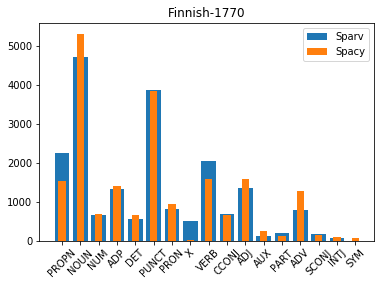

In [73]:
plt.bar(counterSparv.keys(), counterSparv.values(), label="Sparv")
plt.bar(counterSpacy.keys(), counterSpacy.values(), width=0.4, label="Spacy")
plt.xticks(rotation=45)
plt.legend()
plt.title("Finnish-1770")

In [62]:
print("spacy parts: ", counterSpacy['AUX'] + counterSpacy['PART'])
print("sparv parts: ", counterSparv['AUX'] + counterSparv['PART'])

spacy parts:  365
sparv parts:  299


In [57]:
print("spacy aux: ", counterSpacy['AUX'])
print("sprav aux: ", counterSparv['AUX'])

spacy aux:  28
sprav aux:  12


Text(0.5, 1.0, 'Finnish-1870')

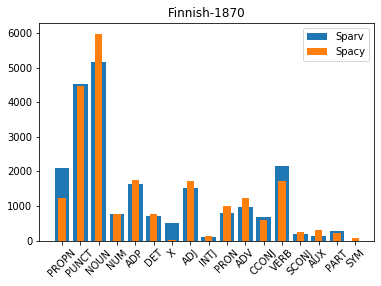

In [74]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
counterSparv, counterSpacy = getPosDistrFin(file_path)
plt.bar(counterSparv.keys(), counterSparv.values(), label="Sparv")
plt.bar(counterSpacy.keys(), counterSpacy.values(), width=0.4, label="Spacy")
plt.xticks(rotation=45)
plt.legend()
plt.title("Finnish-1870")

In [76]:
"""
    Use the first 10,000 paragraphs to get a sense of how the spacy and sparv POS tags compare. 
    TODO: Consider stopping condition of when average seems to settle, doesn't deviate more than some epsilon each checkpoint. 
"""
def getPosDistrSwe(file_path):
    parser = ET.iterparse(file_path, events=('start','end'))
    parser = iter(parser)
    event, root = next(parser)
    counterSparv = Counter()
    counterSpacy = Counter()

    words = ""
    pos = []
    sum_overlaps= 0 
    num_para = 0
    i = 0
    for event, elem in parser:
        if elem.tag == "w":
            if event == "end":
                #print(elem.attrib['pos'])
                words +=  elem.text + " "
                pos.append(elem.attrib['pos'])
                elem.clear()
            root.clear()
        if elem.tag == "paragraph" and event=="end":
            words = words.strip()
            #print("ORIG:", [f'{words.split()[i]}/{pos[i]}' for i in range(len(words.split()))] )
            try:
                pos_sparv =  np.array([msd_to_upos[p] for p in pos])
            except KeyError as k: 
                print(k,i)
                print("ORIG:", [f'{words.split()[i]}/{pos[i]}' for i in range(len(words.split()))] )
                words = ""
                pos = []
                i += 1
                continue
            doc = nlp(words)
            pos_spacy = [token.tag_ for token in doc]
            pos_sparv =  np.array([msd_to_upos[p] for p in pos])
            counterSparv.update(pos_sparv)
            counterSpacy.update(pos_spacy)

            words = ""
            pos =[]
            i +=1
        if i % 1000 == 0 and i != 0: 
            num_para = i
            # print(sum_overlaps/i)
        if i == 10000: break
    num_para = i
    return counterSparv, counterSpacy

Text(0.5, 1.0, 'Swedish-1760')

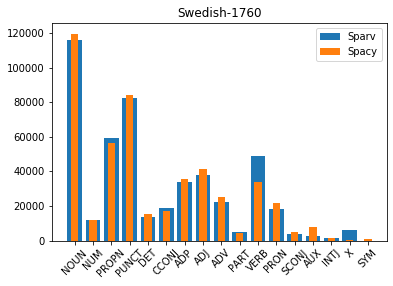

In [79]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1760.xml")
counterSparv, counterSpacy = getPosDistrSwe(file_path)
plt.bar(counterSparv.keys(), counterSparv.values(), label="Sparv")
plt.bar(counterSpacy.keys(), counterSpacy.values(), width=0.4, label="Spacy")
plt.xticks(rotation=45)
plt.legend()
plt.title("Swedish-1760")

Text(0.5, 1.0, 'Swedish-1870')

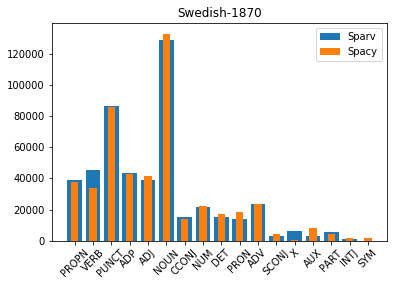

In [77]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
counterSparv, counterSpacy = getPosDistrSwe(file_path)
plt.bar(counterSparv.keys(), counterSparv.values(), label="Sparv")
plt.bar(counterSpacy.keys(), counterSpacy.values(), width=0.4, label="Spacy")
plt.xticks(rotation=45)
plt.legend()
plt.title("Swedish-1870")